In [1]:
import json
import glob
import re
import pandas as pd
from tqdm import tqdm
import PIL
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from IPython.display import Image as IImage
import source
import source.data_preprocessing_utils as data_utils
import source.datasets as datasets
import random
import math
from importlib import reload
from collections import Counter

In [16]:
reload(source.datasets)

<module 'source.datasets' from '/home/pamessina/VQAMed/source/datasets.py'>

In [2]:
mimiccxr_qa_reports = data_utils.load_json_file('/mnt/data/mimic-cxr/qa_adapted_reports.json')

In [3]:
mimiccxr_metadata = pd.read_csv('/mnt/data/mimic-cxr-jpg/mimic-cxr-2.0.0-metadata.csv')

In [4]:
mimiccxr_split = pd.read_csv('/mnt/data/mimic-cxr-jpg/mimic-cxr-2.0.0-split.csv')

In [5]:
iuxray_qa_reports = data_utils.load_json_file('/mnt/workspace/iu-x-ray/dataset/reports/qa_adapted_reports.json')

In [6]:
iuxray_metadata = data_utils.load_json_file('/mnt/workspace/iu-x-ray/dataset/reports/reports.min.json')

In [7]:
iuxray_image_info = data_utils.load_json_file('/mnt/workspace/iu-x-ray/dataset/info.json')

In [8]:
tokenizer = data_utils.Tokenizer('./id2tokens_vqa_mimiccxr+iuxray.pickle', [mimiccxr_qa_reports, iuxray_qa_reports])

In [9]:
len(tokenizer.id2token)

5187

In [10]:
mimiccxr_metadata.columns

Index(['dicom_id', 'subject_id', 'study_id',
       'PerformedProcedureStepDescription', 'ViewPosition', 'Rows', 'Columns',
       'StudyDate', 'StudyTime', 'ProcedureCodeSequence_CodeMeaning',
       'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning'],
      dtype='object')

In [11]:
Counter(mimiccxr_metadata['ViewPosition']),\
Counter(mimiccxr_metadata['ViewCodeSequence_CodeMeaning']),\
Counter(mimiccxr_metadata['PatientOrientationCodeSequence_CodeMeaning'])

(Counter({'PA': 96161,
          'LATERAL': 82853,
          'AP': 147173,
          'LL': 35133,
          nan: 15769,
          'LAO': 3,
          'RAO': 3,
          'AP AXIAL': 2,
          'SWIMMERS': 1,
          'PA LLD': 4,
          'AP LLD': 2,
          'XTABLE LATERAL': 2,
          'AP RLD': 2,
          'PA RLD': 1,
          'LPO': 1}),
 Counter({'postero-anterior': 95858,
          'lateral': 82612,
          'antero-posterior': 146448,
          'left lateral': 35033,
          nan: 16497,
          'Erect': 623,
          'Recumbent': 18,
          'left anterior oblique': 21}),
 Counter({'Erect': 296769, nan: 41166, 'Recumbent': 39175}))

In [17]:
mimiccxr_vqa_train_handler = datasets.VQA_TrainingHandler('MIMIC-CXR',
                                                          tokenizer,
                                                          datasets.default_transform,
                                                          batch_size = 45,
                                                          collate_batch_fn = datasets.collate_batch_fn,
                                                          mimiccxr_qa_reports = mimiccxr_qa_reports,
                                                          mimiccxr_metadata = mimiccxr_metadata,
                                                          mimiccxr_split = mimiccxr_split)

reading MIMIC-CXR splits ...
reading MIMIC-CXR metadata ...


1415it [00:00, 14149.37it/s]

loading MIMIC-CXR vqa dataset ...


227835it [00:20, 11007.83it/s]


splitting data into training and validation ...
generating training and validation datasets ...
generating training and validation dataloaders ...
done!


In [20]:
iuxray_vqa_train_handler = datasets.VQA_TrainingHandler('IU X-Ray',
                                                        tokenizer,
                                                        datasets.default_transform,
                                                        batch_size = 45,
                                                        collate_batch_fn = datasets.collate_batch_fn,
                                                        iuxray_metadata = iuxray_metadata,
                                                        iuxray_image_info = iuxray_image_info,
                                                        iuxray_qa_reports = iuxray_qa_reports)

loading IU X-ray vqa dataset ...
splitting data into training and validation ...
generating training and validation datasets ...
generating training and validation dataloaders ...
done!


In [18]:
len(mimiccxr_vqa_train_handler)

1688800

In [73]:
len(mimiccxr_vqa_train_handler.val_dataset)

810

In [21]:
len(iuxray_vqa_train_handler)

26484

In [22]:
len(iuxray_vqa_train_handler.val_dataset)

360

In [65]:
balanced_train_dataloader = datasets.question_balanced_train_dataloader_generator(mimiccxr_vqa_train_handler)

In [66]:
_aux = next(balanced_train_dataloader)

In [67]:
max(mimiccxr_vqa_train_handler.freqs) / min(mimiccxr_vqa_train_handler.freqs)

27.2

In [71]:
sum(mimiccxr_vqa_train_handler.freqs)

9160

In [10]:
len(iuxray_qa_reports['reports']), len(mimiccxr_qa_reports['reports'])

(3927, 227835)

In [30]:
mimiccxr_qa_adapted_reports['reports'][0]['filepath']

'/mnt/data/mimic-cxr/files/p10/p10703179/s58829627.txt'

In [31]:
mimiccxr_qa_adapted_reports['reports'][0]

{'sentences': ['Heart size is normal.',
  'There are mild aortic knob calcifications.',
  'Cardiomediastinal silhouette and hilar contours are otherwise unremarkable.',
  'Lungs are clear.',
  'Pleural surfaces are clear without effusion or pneumothorax.',
  'No acute cardiopulmonary abnormality.'],
 'invalid': [],
 'unmatched': [5],
 'matched': [0, 1, 2, 3, 4],
 'qa': {'70': [0],
  '78': [1],
  '17': [1],
  '54': [2],
  '65': [2],
  '73': [2],
  '72': [3],
  '48': [4],
  '52': [4]},
 'filepath': '/mnt/data/mimic-cxr/files/p10/p10703179/s58829627.txt'}

In [9]:
mimiccxr_regex = re.compile(r'/(p\d+)/(p\d+)/(s\d+)\.txt')
mimiccxr_regex.findall('/mnt/data/mimic-cxr/files/p10/p10703179/s58829627.txt')

[('p10', 'p10703179', 's58829627')]

In [10]:
count =  0
for report in mimiccxr_qa_adapted_reports['reports']:    
    p1, p2, s1 = mimiccxr_regex.findall(report['filepath'])[0]
    image_files = glob.glob(f'/mnt/workspace/mimic-cxr-jpg/images-small/{p1}/{p2}/{s1}/*.jpg')
    if len(image_files) == 1:
        count += 1

In [11]:
count

102675

In [12]:
mimiccxr_qa_adapted_reports['reports'][0]['filepath']

'/mnt/data/mimic-cxr/files/p10/p10703179/s58829627.txt'

In [13]:
glob.glob('/mnt/workspace/mimic-cxr-jpg/images-small/p10/p10703179/s58829627/*.jpg')

['/mnt/workspace/mimic-cxr-jpg/images-small/p10/p10703179/s58829627/768efca4-214691b8-11c6e785-87c7ef6a-691ddac9.jpg',
 '/mnt/workspace/mimic-cxr-jpg/images-small/p10/p10703179/s58829627/3f1d4d25-bc07dfbd-0d530479-35ef51a0-a45291cc.jpg']

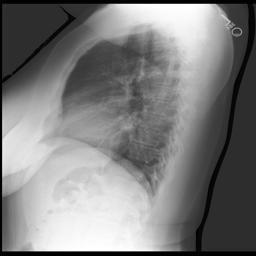

In [17]:
Image('/mnt/workspace/mimic-cxr-jpg/images-small/p10/p10703179/s58829627/768efca4-214691b8-11c6e785-87c7ef6a-691ddac9.jpg')

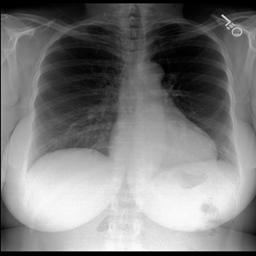

In [45]:
IImage('/mnt/workspace/mimic-cxr-jpg/images-small/p10/p10703179/s58829627/3f1d4d25-bc07dfbd-0d530479-35ef51a0-a45291cc.jpg')

In [6]:
iuxray_metadata = load_json_file('/mnt/workspace/iu-x-ray/dataset/reports/reports.min.json')

In [7]:
count = 0
for report in iuxray_qa_adapted_reports['reports']:    
    if len(iuxray_metadata[report['filename']]['images']) == 1:
        count += 1
count

435

In [34]:
iuxray_metadata[iuxray_qa_adapted_reports['reports'][0]['filename']]

{'filename': '1.xml',
 'images': [{'id': 'CXR1_1_IM-0001-3001',
   'caption': 'Xray Chest PA and Lateral'},
  {'id': 'CXR1_1_IM-0001-4001', 'caption': 'Xray Chest PA and Lateral'}],
 'comparison': 'None.',
 'indication': 'Positive TB test',
 'findings': 'The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.',
 'impression': 'Normal chest x-XXXX.',
 'tags_manual': ['normal'],
 'tags_auto': []}

In [89]:
_info = load_json_file('/mnt/workspace/iu-x-ray/dataset/info.json')

In [116]:
_info["marks"]["broken"][-1] in _info["classification"].keys()

True

In [120]:
_info

{'classification': {'CXR2323_IM-0895-2001.png': 'lateral-left',
  'CXR1946_IM-0615-1001.png': 'frontal',
  'CXR544_IM-2148-1002.png': 'lateral-left',
  'CXR1402_IM-0257-3001.png': 'lateral-left',
  'CXR573_IM-2171-12012.png': 'frontal',
  'CXR1947_IM-0616-1001.png': 'frontal',
  'CXR3136_IM-1475-1001.png': 'frontal',
  'CXR37_IM-1847-0001-0002.png': 'frontal',
  'CXR3979_IM-2038-2001.png': 'lateral-left',
  'CXR188_IM-0569-1002.png': 'lateral-left',
  'CXR1775_IM-0508-1001.png': 'frontal',
  'CXR518_IM-2131-2001.png': 'lateral-left',
  'CXR2202_IM-0811-1002.png': 'lateral-left',
  'CXR3541_IM-1733-0001-0002.png': 'frontal',
  'CXR2855_IM-1263-1001.png': 'frontal',
  'CXR3807_IM-1917-1001.png': 'frontal',
  'CXR531_IM-2140-2001.png': 'lateral-left',
  'CXR1279_IM-0185-1001.png': 'frontal',
  'CXR2780_IM-1218-1003.png': 'lateral-left',
  'CXR3225_IM-1525-2001.png': 'lateral-left',
  'CXR3533_IM-1726-2001.png': 'lateral-left',
  'CXR901_IM-2409-3001.png': 'frontal',
  'CXR3016_IM-1392-200

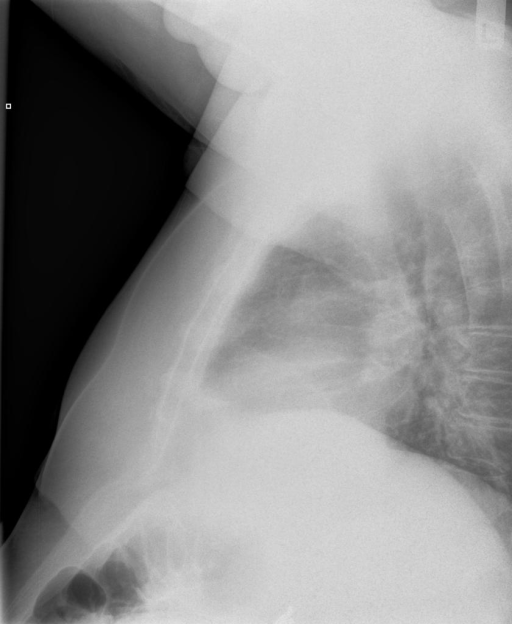

In [119]:
IImage(f'/mnt/workspace/iu-x-ray/dataset/images/{_info["marks"]["wrong"][-10]}')

In [108]:
_info['marks'].keys()

dict_keys(['wrong', 'rotated', 'broken', 'rotated_left', 'rotated_right', 'rotated_bottom'])

In [190]:
def cyclic_dataloader_generator(dataloader):
    while True:
        for batch in dataloader:
            yield batch

In [121]:
class IUXRay_VQADataset(Dataset):
    
    def __init__(self, tokenizer, iuxray_metadata, iuxray_image_info, iuxray_qa_adapted_reports):     
        
        self.report_ids = []
        self.question_ids = []
        self.images = []
        self.questions = []
        self.answers = []
        
        question_list = iuxray_qa_adapted_reports['questions']
        
        invalid_images = set()
        invalid_images.update(iuxray_image_info['marks']['wrong'])
        invalid_images.update(iuxray_image_info['marks']['broken'])
        
        for ri, report in enumerate(iuxray_qa_adapted_reports['reports']):
            
            r_metadata = iuxray_metadata[report['filename']]
            r_images = r_metadata['images']
            sentences = report['sentences']
            
            image_path = None
            
            if len(r_images) == 1:
                image_name = f'{r_images[0]["id"]}.png'
                if image_name not in invalid_images:
                    image_path = f'/mnt/workspace/iu-x-ray/dataset/images/{image_name}'
            else:
                for elem in r_images:
                    image_name = f'{elem["id"]}.png'
                    if image_name not in invalid_images and iuxray_image_info['classification'][image_name] == 'frontal':
                        image_path = f'/mnt/workspace/iu-x-ray/dataset/images/{image_name}'
                        break

            if image_path:
                for q_idx, a_idxs in report['qa'].items():
                    q_idx = int(q_idx)
                    question = question_list[q_idx]
                    answer = ' '.join(sentences[i] for i in a_idxs)
                    self.report_ids.append(ri)
                    self.question_ids.append(q_idx)
                    self.images.append(image_path)
                    self.questions.append(tokenizer.string2ids(question.lower()))
                    self.answers.append(tokenizer.string2ids(answer.lower()))
                    
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):    
        return dict(
            idx=i,
            i=self.transform(Image.open(self.images[i]).convert('RGB')),
            q=self.questions[i],
            a=self.answers[i],
        )

In [176]:
class VQADataset(Dataset):
    
    def __int__(self, images, questions, answers, indices):
        self.images = images
        self.questions = questions
        self.answers = answers
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        return dict(
            idx=i,
            i=self.transform(Image.open(self.images[idx]).convert('RGB')),
            q=self.questions[idx],
            a=self.answers[idx],
        )

class MIMICCXR_VQADataset_training:
    
    mimiccxr_image_regex = re.compile(r'/p(\d+)/p(\d+)/s(\d+)\.txt')
    
    def __init__(self, tokenizer, mimiccxr_qa_adapted_reports, mimiccxr_metadata, mimiccxr_split, transform):        
        
        self.transform = transform
        self.preprocess_data(tokenizer, mimiccxr_qa_adapted_reports, mimiccxr_metadata, mimiccxr_split)
        self.split_data_train_val()
        self.generate_train_datasets_per_question()
    
    def preprocess_data(self, tokenizer, mimiccxr_qa_adapted_reports, mimiccxr_metadata, mimiccxr_split):
        
        self.report_ids = []
        self.question_ids = []        
        self.images = []
        self.questions = []
        self.answers = []
        
        print('reading MIMIC-CXR metadata ...')
        
        split_dict = { (r.subject_id, r.study_id, r.dicom_id) : r.split for r in mimiccxr_split.iterrows() }
        
        image_views_dict = dict()
        for r in mimiccxr_metadata.iterrows():
            key = (r.subject_id, r.study_id)
            try:
                views = data[key]
            except KeyError:
                views = data[key] = []
            views.append((r.dicom_id, r.ViewPosition))
        
        question_list = mimiccxr_qa_adapted_reports['questions']
        
        print('loading MIMIC-CXR vqa dataset ...')
        
        for ri, report in tqdm(enumerate(mimiccxr_qa_adapted_reports['reports'])):
            
            sentences = report['sentences']
            part_id, subject_id, study_id = map(int, self.mimiccxr_image_regex.findall(report['filepath'])[0])
            views = image_views_dict[(subject_id, study_id)]
            images = glob.glob(f'/mnt/workspace/mimic-cxr-jpg/images-small/p{part_id}/p{subject_id}/s{study_id}/*.jpg')
            assert len(views) == len(images)
            
            dicom_id = None
            if len(views) == 1:
                dicom_id = views[0][0]
            else:
                for view in views:
                    if view[1] == 'PA' or view[1] == 'AP':
                        dicom_id = view[0]
                        break
                
            if dicom_id and split_dict[(subject_id, study_id, dicom_id)] != 'test':
                image_path = f'/mnt/workspace/mimic-cxr-jpg/images-small/p{part_id}/p{subject_id}/s{study_id}/{dicom_id}.jpg'
                for q_idx, a_idxs in report['qa'].items():
                    q_idx = int(q_idx)
                    question = question_list[q_idx]
                    answer = ' '.join(sentences[i] for i in a_idxs)
                    self.report_ids.append(ri)
                    self.question_ids.append(q_idx)
                    self.images.append(image_path)
                    self.questions.append(tokenizer.string2ids(question.lower()))
                    self.answers.append(tokenizer.string2ids(answer.lower()))
    
    def split_data_train_val(self, n_vals_per_question=10, min_question_count=100):
        
        tmp = dict()
        for i, (qi, a) in enumerate(zip(self.question_ids, self.answers)):
            try:
                list_ = tmp[qi]
            except KeyError:
                list_ = tmp[qi] = []
            list_.append((len(a), i))
        train_indices = {k:[] for k in tmp.keys()}
        val_indices = []
        for k, list_ in tmp.items():
            list_.sort()
            if len(list_) >= min_question_count:
                chunk_size = len(list_) // n_tests_per_question
                offset = 0
                while offset < len(list_):
                    min_i = offset
                    max_i = min(offset + chunk_size, len(list_)) - 1
                    if max_i - min_i + 1 == chunk_size:
                        val_i = random.randint(min_i, max_i)
                    else:
                        val_i = None
                    for i in range(min_i, max_i+1):
                        if i == val_i:
                            val_indices.append(list_[val_i][1])
                        else:
                            train_indices[k].append(list_[i][1])
                    offset += chunk_size
            else:
                train_indices[k].extend(e[1] for e in list_)
                
        self.train_indices = train_indices
        self.val_indices = val_indices        

    def generate_train_val_datasets(self):
        
        self.train_datasets = []
        for indices in self.train_indices.values():
            self.train_datasets.append(VQADataset(self.images, self.questions, self.answers, indices))
        
        self.val_dataset = VQADataset(self.images, self.questions, self.answers, self.val_indices)
        
            
    def generate_dataloaders(self, batch_size, collate_batch_fn):
        
        self.train_dataloaders = []
        for dataset in self.train_datasets:
            self.train_dataloaders.append(DataLoader(dataset,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     collate_fn=collate_batch_fn))
        
        self.val_dataloader = Dataloader(self.val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         collate_fn=collate_batch_fn)
    
    def question_balanced_train_dataloader_generator(self, min_max_ratio = 2):
        
        min_count = min(len(d) for d in self.train_datasets)
        max_count = min(len(d) for d in self.train_datasets)
        self.freqs = []
        dataset_indices = []
        for i, dataset in enumerate(self.train_datasets):
            freq = 10 * (1 + (min_max_ratio - 1) * (len(dataset) - min_count) / (max_count - min_count))
            freq = math.ceil(freq * math.sqrt(len(dataset) / min_count))
            self.freqs.append(freq)
            for _ in range(freq):
                dataset_indices.append(i)
        
        cyclic_dataloaders = [cyclic_dataloader_generator(d) for d in self.train_dataloaders]
        
        while True:            
            random.shuffle(dataset_indices)
            for i in dataset_indices:
                yield next(cyclic_dataloaders[i])
            
        
        
#         self.transform = transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ])

In [9]:
tokenizer = Tokenizer([mimiccxr_qa_adapted_reports, iuxray_qa_adapted_reports])

1149350it [00:07, 144613.46it/s]


In [10]:
tokenizer.ignore_regex

re.compile(r'^(\d+(cm|mm|st|th|nd|rd)?|xxxx|jj|[()\-\\/+#*=><%?;!].*|[:,.].+)$',
re.UNICODE)

In [11]:
len(tokenizer.id2token)

5187

In [12]:
tokenizer.token2id['.']

6

In [44]:
iuxray_metadata[iuxray_qa_adapted_reports['reports'][0]['filename']]

{'filename': '1.xml',
 'images': [{'id': 'CXR1_1_IM-0001-3001',
   'caption': 'Xray Chest PA and Lateral'},
  {'id': 'CXR1_1_IM-0001-4001', 'caption': 'Xray Chest PA and Lateral'}],
 'comparison': 'None.',
 'indication': 'Positive TB test',
 'findings': 'The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.',
 'impression': 'Normal chest x-XXXX.',
 'tags_manual': ['normal'],
 'tags_auto': []}

In [122]:
iuxray_image_info = load_json_file('/mnt/workspace/iu-x-ray/dataset/info.json')

In [123]:
iuxray_vqa_dataset = IUXRay_VQADataset(tokenizer, iuxray_metadata, iuxray_image_info, iuxray_qa_adapted_reports)

In [125]:
len(iuxray_vqa_dataset)

26484

{'sentences': ['The cardiac silhouette and mediastinum size are within normal limits.', 'There is no pulmonary edema.', 'There is no focal consolidation.', 'There are no XXXX of a pleural effusion.', 'There is no evidence of pneumothorax.', 'Normal chest x-XXXX.'], 'invalid': [3, 5], 'unmatched': [], 'matched': [0, 1, 2, 4], 'qa': {'65': [0], '73': [0], '72': [1], '25': [1], '22': [2], '52': [4]}, 'filename': '1.xml'}

<s> what about edema </s>
<s> there is no pulmonary edema . </s>



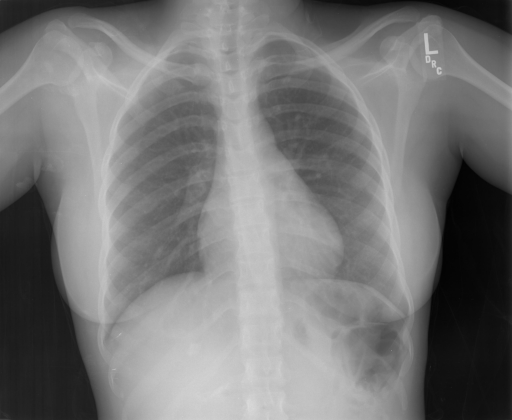

In [130]:
_aux = iuxray_vqa_dataset[3]
print(iuxray_qa_adapted_reports['reports'][ iuxray_vqa_dataset.ids[_aux['idx']][0] ])
print()
print(tokenizer.ids2sentence(_aux['q']))
print(tokenizer.ids2sentence(_aux['a']))
print()
IImage(iuxray_vqa_dataset.images[_aux['idx']])

In [72]:
mimiccxr_metadata = pd.read_csv('/mnt/data/mimic-cxr-jpg/mimic-cxr-2.0.0-metadata.csv')

In [174]:
mimiccxr_split = pd.read_csv('/mnt/data/mimic-cxr-jpg/mimic-cxr-2.0.0-split.csv')

In [188]:
mimiccxr_split.groupby('split').count()

,dicom_id,study_id,subject_id
split,,,
test,5159,5159,5159
train,368960,368960,368960
validate,2991,2991,2991


In [79]:
mimiccxr_vqa_dataset = MIMICCXR_VQADataset(tokenizer, mimiccxr_metadata, mimiccxr_qa_adapted_reports)

reading MIMICCXR metadata ...


1096it [00:00, 10945.68it/s]

loading MIMICCXR vqa dataset ...


227835it [00:28, 8083.97it/s]


In [173]:
mimiccxr_metadata

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,21800626,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,19999733,57132437,CHEST (PA AND LAT),PA,3056,2544,21520708,224550.171,CHEST (PA AND LAT),postero-anterior,Erect
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,19999733,57132437,CHEST (PA AND LAT),LATERAL,3056,2544,21520708,224550.171,CHEST (PA AND LAT),lateral,Erect
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,19999987,55368167,CHEST (PORTABLE AP),AP,2544,3056,21451104,51448.218,CHEST (PORTABLE AP),antero-posterior,Erect
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,19999987,58621812,CHEST (PORTABLE AP),AP,3056,2544,21451102,202809.234,CHEST (PORTABLE AP),antero-posterior,Erect


In [169]:
def split_vqa_dataset(n_tests_per_question=10, min_question_count=100):
    tmp = dict()
    for i, ((ri, qi), a) in enumerate(zip(mimiccxr_vqa_dataset.ids, mimiccxr_vqa_dataset.answers)):
        try:
            list_ = tmp[qi]
        except KeyError:
            list_ = tmp[qi] = []
        list_.append((len(a), i))
    train_indices = {k:[] for k in tmp.keys()}
    test_indices = {k:[] for k in tmp.keys()}
    for k, list_ in tmp.items():
        list_.sort()
        if len(list_) >= min_question_count:
            chunk_size = len(list_) // n_tests_per_question
            offset = 0
            while offset < len(list_):
                min_i = offset
                max_i = min(offset + chunk_size, len(list_)) - 1
                if max_i - min_i + 1 == chunk_size:
                    ti = random.randint(min_i, max_i)
                else:
                    ti = None
                for i in range(min_i, max_i+1):
                    if i == ti:                        
                        test_indices[k].append(list_[ti][1])
                    else:
                        train_indices[k].append(list_[i][1])
                offset += chunk_size
        else:
            train_indices[k].extend(e[1] for e in list_)
    return train_indices, test_indices, tmp

In [170]:
_train, _test, _tmp = split_vqa_dataset()

In [171]:
len(_train), len(_test), len(_tmp)

(84, 84, 84)

In [172]:
for k in _tmp.keys():
    assert len(_train[k]) + len(_test[k]) == len(_tmp[k])
    print(len(_train[k]), len(_test[k]), len(_tmp[k]))

91274 10 91284
19518 10 19528
13154 10 13164
48829 10 48839
88039 10 88049
106519 10 106529
177005 10 177015
165673 10 165683
134858 10 134868
67218 10 67228
62866 10 62876
45660 10 45670
55978 10 55988
60452 10 60462
42320 10 42330
786 10 796
7041 10 7051
57064 10 57074
2020 10 2030
12152 10 12162
5652 10 5662
923 10 933
9961 10 9971
28511 10 28521
95571 10 95581
362 10 372
10847 10 10857
6463 10 6473
756 10 766
493 10 503
221 10 231
6510 10 6520
7467 10 7477
3997 10 4007
23095 10 23105
2402 10 2412
76868 10 76878
8463 10 8473
18762 10 18772
20242 10 20252
3422 10 3432
9662 10 9672
9243 10 9253
1490 10 1500
12502 10 12512
2959 10 2969
2510 10 2520
15072 10 15082
9763 10 9773
4482 10 4492
804 10 814
2746 10 2756
2213 10 2223
5027 10 5037
4541 10 4551
8942 10 8952
1839 10 1849
1502 10 1512
4713 10 4723
1539 10 1549
671 10 681
3035 10 3045
2549 10 2559
1845 10 1855
3661 10 3671
209 10 219
777 10 787
726 10 736
65 0 65
413 10 423
384 10 394
783 10 793
1861 10 1871
1096 10 1106
1997 10 200

In [149]:
for k, v in _tmp.items():
    print(k, len(v))

70 91284
78 19528
17 13164
54 48839
65 88049
73 106529
72 177015
48 165683
52 134868
11 67228
22 62876
55 45670
45 55988
7 60462
50 42330
47 796
64 7051
25 57074
0 2030
29 12162
24 5662
41 933
79 9971
19 28521
60 95581
16 372
62 10857
57 6473
80 766
9 503
71 231
6 6520
36 7477
35 4007
68 23105
33 2412
81 76878
53 8473
82 18772
61 20252
58 3432
74 9672
30 9253
49 1500
77 12512
15 2969
31 2520
75 15082
66 9773
42 4492
76 814
28 2756
38 2223
44 5037
26 4551
40 8952
27 1849
2 1512
21 4723
39 1549
5 681
43 3045
34 2559
1 1855
69 3671
10 219
51 787
59 736
46 65
23 423
3 394
14 793
32 1871
63 1106
18 2007
4 597
12 761
37 213
8 151
13 587
83 360
67 468
56 6
20 16


In [81]:
len(mimiccxr_vqa_dataset)

1714934

{'sentences': ['-year-old male with history of fever postop.', 'Frontal and lateral views of the chest were obtained.', 'Haziness projecting over the left hemidiaphragm on the frontal view with apparent flattening of the diaphragm is felt to more likely be due to overlying soft tissue and possible artifact as no evidence of consolidation or pleural effusion is seen on the lateral view.', 'The cardiac and mediastinal silhouettes are unremarkable.', 'There is no overt pulmonary edema.', 'No evidence of pneumothorax.', 'Partially visualized is lower cervical spine metallic hardware.'], 'invalid': [0, 1], 'unmatched': [], 'matched': [2, 3, 4, 5, 6], 'qa': {'48': [2], '22': [2], '60': [2, 6], '68': [2], '33': [2], '58': [2], '65': [3], '73': [3], '72': [4], '25': [4], '52': [5], '11': [6]}, 'filepath': '/mnt/data/mimic-cxr/files/p10/p10865538/s51663634.txt'}

<s> what about consolidation </s>
<s> haziness projecting over the left hemidiaphragm on the frontal view with apparent flattening of

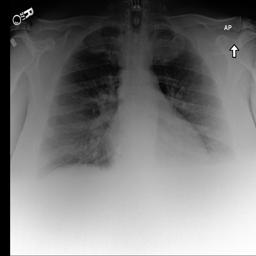

In [88]:
_aux = mimiccxr_vqa_dataset[531]
print(mimiccxr_qa_adapted_reports['reports'][ mimiccxr_vqa_dataset.ids[_aux['idx']][0] ])
print()
print(tokenizer.ids2sentence(_aux['q']))
print(tokenizer.ids2sentence(_aux['a']))
print()
IImage(mimiccxr_vqa_dataset.images[_aux['idx']])

In [40]:
!cat /mnt/data/mimic-cxr/files/p10/p10251549/s55334905.txt

                                 FINAL REPORT
 EXAMINATION:  Portable chest radiograph
 
 INDICATION:  ___ year old man with CHF and pancreatitis new O2 requirement
 while on IV fluid. Volume status difficult to assess  // Eval for pul edema
 
 TECHNIQUE:  Portable AP chest
 
 COMPARISON:  ___ CT abdomen/pelvis
 
 FINDINGS: 
 
 Indistinct right basilar opacity is likely atelectasis as identified on recent
 CT.  Trace left pleural effusion.  Severe cardiomegaly without pulmonary
 vascular congestion or edema.  A left pectoralis pacemaker with right atrial
 and right ventricular leads is noted.  Cardiomediastinal hilar silhouettes are
 unremarkable.  Incidental note is made of a moderate hiatal hernia and
 multiple contiguous, healed left rib fractures.
 
 IMPRESSION: 
 
 Right basilar atelectasis.  No pulmonary edema.  Moderate hiatal hernia.


In [41]:
!ls /mnt/workspace/mimic-cxr-jpg/images-small/p10/p10251549/s55334905/*.jpg

/mnt/workspace/mimic-cxr-jpg/images-small/p10/p10251549/s55334905/bce7246e-5edff07e-b95772e6-4cc1ae42-17239e30.jpg


In [45]:
mimiccxr_vqa_dataset.images[_aux['idx']]

'/mnt/workspace/mimic-cxr-jpg/images-small/p10/p10251549/s55334905/bce7246e-5edff07e-b95772e6-4cc1ae42-17239e30.jpg'

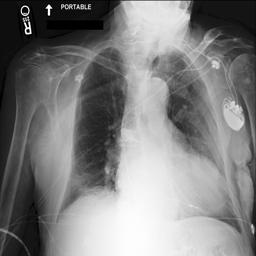

In [42]:
IImage('/mnt/workspace/mimic-cxr-jpg/images-small/p10/p10251549/s55334905/bce7246e-5edff07e-b95772e6-4cc1ae42-17239e30.jpg')

In [52]:
df = pd.read_csv('/mnt/data/mimic-cxr-jpg/mimic-cxr-2.0.0-metadata.csv')

In [59]:
df

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,21800626,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,19999733,57132437,CHEST (PA AND LAT),PA,3056,2544,21520708,224550.171,CHEST (PA AND LAT),postero-anterior,Erect
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,19999733,57132437,CHEST (PA AND LAT),LATERAL,3056,2544,21520708,224550.171,CHEST (PA AND LAT),lateral,Erect
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,19999987,55368167,CHEST (PORTABLE AP),AP,2544,3056,21451104,51448.218,CHEST (PORTABLE AP),antero-posterior,Erect
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,19999987,58621812,CHEST (PORTABLE AP),AP,3056,2544,21451102,202809.234,CHEST (PORTABLE AP),antero-posterior,Erect


In [58]:
df.groupby('ViewPosition').count()

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
ViewPosition,,,,,,,,,,,
AP,147173,147173,147173,146429,147173,147173,147173,147173,147173,146663,122441
AP AXIAL,2,2,2,2,2,2,2,2,2,2,2
AP LLD,2,2,2,2,2,2,2,2,2,2,0
AP RLD,2,2,2,2,2,2,2,2,2,2,0
LAO,3,3,3,1,3,3,3,3,3,3,3
LATERAL,82853,82853,82853,82572,82853,82853,82853,82853,82853,82853,82612
LL,35133,35133,35133,19116,35133,35133,35133,35133,35133,35033,35033
LPO,1,1,1,1,1,1,1,1,1,1,0
PA,96161,96161,96161,78837,96161,96161,96161,96161,96161,96045,95853


In [64]:
df

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,21800626,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,19999733,57132437,CHEST (PA AND LAT),PA,3056,2544,21520708,224550.171,CHEST (PA AND LAT),postero-anterior,Erect
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,19999733,57132437,CHEST (PA AND LAT),LATERAL,3056,2544,21520708,224550.171,CHEST (PA AND LAT),lateral,Erect
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,19999987,55368167,CHEST (PORTABLE AP),AP,2544,3056,21451104,51448.218,CHEST (PORTABLE AP),antero-posterior,Erect
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,19999987,58621812,CHEST (PORTABLE AP),AP,3056,2544,21451102,202809.234,CHEST (PORTABLE AP),antero-posterior,Erect


In [66]:
_tmp = dict()
for subject_id, study_id, dicom_id, view_pos in zip(df['subject_id'], df['study_id'], df['dicom_id'], df['ViewPosition']):
    try:
        _list = _tmp[(subject_id, study_id)]
    except KeyError:
        _list = _tmp[(subject_id, study_id)] = []
    _list.append((dicom_id, view_pos))

In [70]:
_tmp[(10000032, 50414267)]

[('02aa804e-bde0afdd-112c0b34-7bc16630-4e384014', 'PA'),
 ('174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962', 'LATERAL')]